# DS@GT Kaggle CLEF - Fall 2024 Internal Competition

Author: Charlie Clark \
Date: November 12, 2024

First, let's import all the necessary libraries and packages.

In [1]:
from typing import Dict, Tuple
import contextlib

from transformers import BertForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/hice1/cclark339/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Data

Now, we need to load in the training data.

In [2]:
df = pd.read_csv('data/train/train.csv')
df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


We should also split it into training and validation sets.

In [3]:
test_size = 0.1

In [4]:
X, y = df.drop(columns=['author']), df[['author']]

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (19579, 2)
y shape: (19579, 1)


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_valid shape: {X_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train shape: (17621, 2)
y_train shape: (17621, 1)

X_valid shape: (1958, 2)
y_valid shape: (1958, 1)


## Tokenize the Data

Next, we'll use a pre-defined tokenizer to tokenize training and validation texts.

In [6]:
max_length = 512

In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [8]:
train_tokens = tokenizer(list(X_train['text']), padding=True, truncation=True, max_length=max_length)
valid_tokens = tokenizer(list(X_valid['text']), padding=True, truncation=True, max_length=max_length)

## Encode the Labels

At this point, we should encode the labels into numerical values.

In [9]:
label2int = {
    'EAP': 0,
    'HPL': 1,
    'MWS': 2
}

y_train = y_train['author'].map(label2int).to_numpy()
y_valid = y_valid['author'].map(label2int).to_numpy()

## Implement a Cuatom Dataset Class

Now, we need to define a class that stores the generated tokens. Our class should be applicable for both training and validation sets.

In [40]:
class TokensDataset(Dataset):
    def __init__(self, X, tokens, labels, device):
        self.X = X
        self.tokens = tokens
        self.labels = list(labels) if labels is not None else None
        self.device = device

    def __len__(self) -> int:
        return self.X.shape[0]
    
    def __getitem__(self, index) -> Dict:
        item = {}
        for key, value in self.tokens.items():
            item[key] = torch.tensor(value[index])

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[index])
        
        return item

## Load the Data into PyTorch DataLoaders

Next, we'll create instances of our TokensDataset class for both the training and validation sets, and then we'll wrap them in PyTorch DataLoaders.

We'll also define some of the data-specific hyperparameters, like batch size.

In [11]:
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
train_dataset = TokensDataset(X_train, train_tokens, y_train, device=device)
valid_dataset = TokensDataset(X_valid, valid_tokens, y_valid, device=device)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Initialize BERT Model, AdamW Optimizer, and Loss Function

Now, we need to initialize our model (BERT) and optimizer (AdamW). We'll also define model-specific parameters, like learning rate.

In [14]:
lr = 1e-5

In [29]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the Model

Next, we'll fine-tune our pre-trained BERT model on our training dataset, performing simultaneous validation as well.

In [30]:
num_epochs = 2

In [64]:
def inner_loop(dataloader, model, optimizer, loss_fn, train=True) -> Tuple[float, float, Dict]:
    loop = tqdm.tqdm(dataloader, unit='batch')

    loss = None
    acc = None
    
    probs_dict = {
        'id': [],
        'EAP': [],
        'HPL': [],
        'MWS': []
    }
    
    test_flag = False
    for j, batch in enumerate(loop):
        batch = {key: value.to(device) for key, value in batch.items()}
        test_flag = ('labels' not in list(batch.keys()))
        

        # forward pass
        with contextlib.nullcontext() if train else torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        logits = outputs.logits
        if not test_flag:
            loss = loss_fn(logits, batch['labels']).mean()

        # backward pass
        optimizer.zero_grad()
        if train and not test_flag:
            loss.backward()
            optimizer.step()

        # prediction
        probs = torch.nn.functional.softmax(logits, dim=1)
        y_pred = probs.argmax(dim=1)
        
        if not test_flag:
            acc = accuracy_score(batch['labels'].cpu().detach(), y_pred.cpu().detach())

            # set tqdm postfix
            loop.set_postfix(loss=loss.item(), acc=acc)
        else:
            for i, prob in enumerate(probs):
                probs_dict['id'] += [dataloader.dataset.X['id'].iloc[128 * j + i]]
                probs_dict['EAP'] += [prob[0].cpu().detach().item()]
                probs_dict['HPL'] += [prob[1].cpu().detach().item()]
                probs_dict['MWS'] += [prob[2].cpu().detach().item()]

    return loss, acc, probs_dict

In [32]:
train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    # train
    train_loss, train_acc, _ = inner_loop(train_dataloader, model, optimizer, loss_fn, train=True)

    # validate
    valid_loss, valid_acc, _ = inner_loop(valid_dataloader, model, optimizer, loss_fn, train=False)

    # append losses and accuracies
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

100%|██████████| 16/16 [00:02<00:00,  7.76batch/s, acc=1, loss=0.116]    


## Plot Loss and Accuracy Curves

At this point, we'll plot our loss and accuracy curves.

In [33]:
train_losses = [train_loss.cpu().detach() for train_loss in train_losses]
valid_losses = [valid_loss.cpu().detach() for valid_loss in valid_losses]

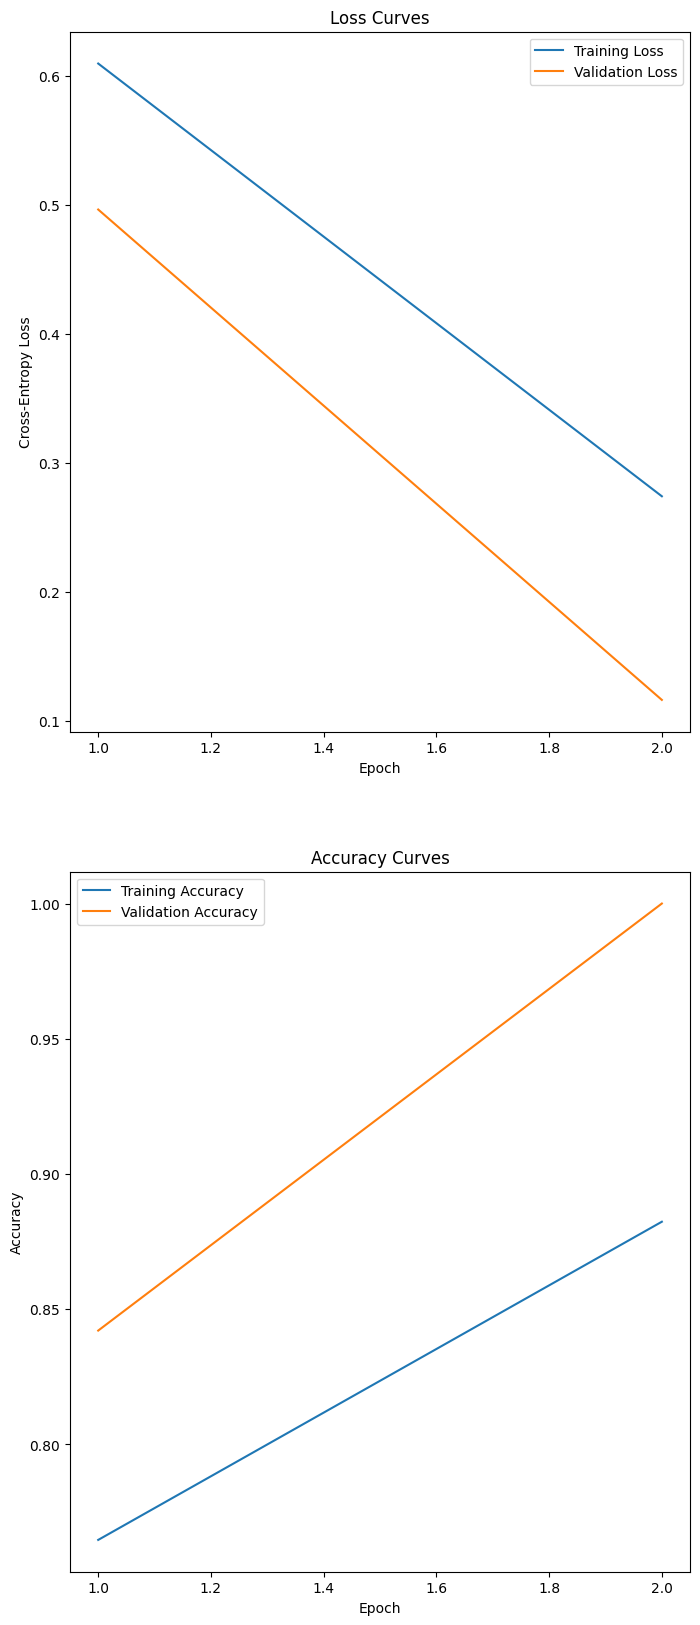

In [34]:
plt.figure(figsize=(8, 20))

# plot losses
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, color='tab:blue', label='Training Loss')
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, color='tab:orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Curves')
plt.legend()

# plot accuracies
plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(train_accs) + 1), train_accs, color='tab:blue', label='Training Accuracy')
plt.plot(np.arange(1, len(valid_accs) + 1), valid_accs, color='tab:orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

## Repeat Previous Steps (Except Training) on Test Set

Lastly, we need to repeat our previous steps to generate our test predictions for submission.

In [35]:
df = pd.read_csv('data/test/test.csv')
df

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...
...,...,...
8387,id11749,All this is now the fitter for my purpose.
8388,id10526,I fixed myself on a wide solitude.
8389,id13477,It is easily understood that what might improv...
8390,id13761,"Be this as it may, I now began to feel the ins..."


In [36]:
X_test = df.copy()

print(f'X_test shape: {X_test.shape}')

X_test shape: (8392, 2)


In [37]:
test_tokens = tokenizer(list(X_test['text']), padding=True, truncation=True, max_length=max_length)

In [77]:
test_dataset = TokensDataset(X_test, test_tokens, None, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [82]:
_, _, y_probs = inner_loop(test_dataloader, model, optimizer, loss_fn, train=False)

100%|██████████| 66/66 [00:23<00:00,  2.77batch/s]


In [83]:
y_probs = pd.DataFrame(y_probs)
y_probs

,id,EAP,HPL,MWS
0,id02310,0.024197,0.058086,0.917717
1,id24541,0.973773,0.021349,0.004878
2,id00134,0.016057,0.968966,0.014977
3,id27757,0.134692,0.853712,0.011596
4,id04081,0.390223,0.502815,0.106962
...,...,...,...,...
8387,id11749,0.195887,0.060416,0.743697
8388,id10526,0.336586,0.014189,0.649226
8389,id13477,0.671160,0.306234,0.022607
8390,id13761,0.062480,0.010625,0.926894


In [ ]:
pd.to_csv('submission.csv', )